# Imports

In [4]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# Sequences

Let's build a Gaussian sin function from which we will sample.

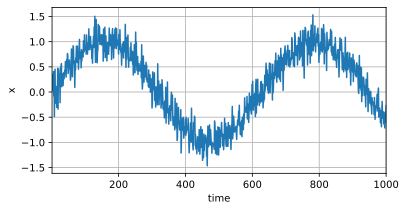

In [5]:
class Data(d2l.DataModule):
    def __init__(self, batch_size = 16, T = 1000, num_train=600, tau = 4):
        self.save_hyperparameters()
        self.time = torch.arange(
            start=1,
            end=T+1,
            dtype=torch.float32
        )
        self.x = torch.sin(0.01*self.time) + torch.randn(T) * 0.2

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

Let's model this as a $\tau^{th}$-order Markov problem, by creating 600 samples of length $\tau$:

In [6]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T - self.tau + i] for i in range(self.tau)]
    print(features)
    self.features = torch.stack(features, 1)
    print(self.features)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    print(self.labels)
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

In [7]:
data.get_dataloader(False)
print(data.x)

[tensor([ 0.0249,  0.0704,  0.3463,  0.2045,  0.4054, -0.0790,  0.4054, -0.4883,
         0.1292,  0.4519, -0.2224, -0.0919,  0.1105,  0.0757, -0.3048, -0.0822,
        -0.0229,  0.4700, -0.3379,  0.4566,  0.3836,  0.2878,  0.1048,  0.3049,
        -0.2108,  0.4844,  0.2004,  0.5243,  0.5637,  0.1050,  0.3131,  0.3613,
         0.3332,  0.1273,  0.2842,  0.3832,  0.2639,  0.3601,  0.4335,  0.3772,
         0.6029,  0.4518,  0.2971,  0.5622,  0.6444,  0.4983,  0.7642,  0.7407,
         0.3675,  0.4617,  0.5400,  0.5887,  0.6358,  0.4610,  0.4791,  0.2366,
         0.2922,  0.4943,  0.8524,  0.6885,  0.4630,  0.3045,  0.7269,  0.9170,
         0.8897,  0.5640,  0.6266,  0.5064,  0.0933,  0.4477,  0.4307,  0.6717,
         0.6959,  0.9111,  0.5935,  0.6853,  0.9106,  0.5803,  0.7826,  0.4557,
         0.5841,  0.8324,  1.0447,  0.6646,  0.7958,  0.7183,  0.7842,  0.4819,
         0.8408,  0.6128,  0.7806,  0.6872,  0.8128,  0.7017,  1.0168,  0.8342,
         0.7968,  1.1346,  0.8380,  0.8

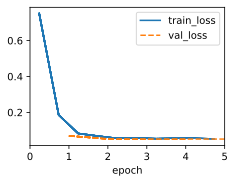

In [8]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

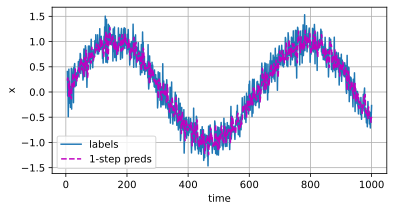

In [9]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

We can now try to make a $k$-step ahead prediction:

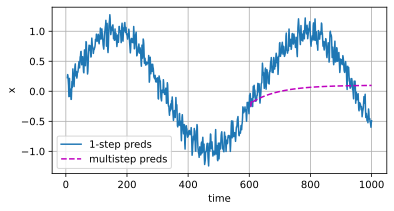

In [10]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1))
    )
    
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train + data.tau:]],
         [onestep_preds, multistep_preds[data.num_train + data.tau:]],
         'time', 'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

These terrible results are due to error accumulation. We can try with different values of k:

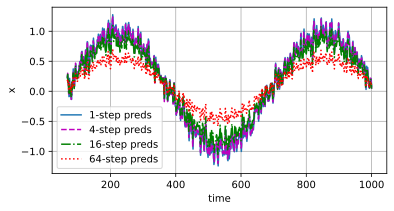

In [11]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i + data.T - data.tau - k + 1])
    
    # The (i+tau)-th element stores the (i+1) - step ahead predictions

    for i in range(k):
        preds = model(torch.stack(features[i : i + data.tau], 1))
        features.append(preds.reshape(-1))

    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau + steps[-1] - 1:],
         [preds[k-1].detach().numpy() for k in steps],
         'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

We can only go up to 4-step ahead preds.

# Converting raw text into sequence data

This, essentially, consists of converting sentences into tokens and indexing them to a dictionary, in order to obtain a string of numbers rather than a string of words.

In [12]:
import collections
import random
import re
import torch
from d2l import torch as d2l

Let's read the raw text into a string:

In [13]:
class TimeMachine(d2l.DataModule):      #@save
    """The Time Machine dataset"""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt',
                             self.root, '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()
        
data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

Let's ignore punctuation and capitalization.

In [14]:
@d2l.add_to_class(TimeMachine)      #@save
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

## Tokenization

The following tokenization takes place on characters.

In [15]:
@d2l.add_to_class(TimeMachine)      #@save
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

## Vocabulary

A vocabulary is a class that maps each token a distinct index.\
Tokens that are too rare or unknown in the vocabulary are both tagged as unknown.

In [16]:
class Vocab:      #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        #Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse = True)

        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + 
                                            [token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]
    
    @property
    def unk(self):      # Index for the unknown token
        return self.token_to_idx['<unk>']

Let's create an instance vocabulary for our dataset:

In [17]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices: ', indices)
print('tokens: ', vocab.to_tokens(indices))

indices:  [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
tokens:  ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


We can now write a `build` method which returns corpus, a list of token indices, and vocab, the vocabulary of the Time Machine corpus.

In [18]:
@d2l.add_to_class(TimeMachine)  #@save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

## Exploratory language statistic

In [19]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

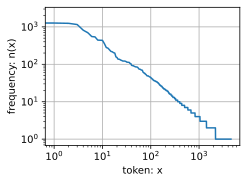

In [20]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

and this is essentially *Zipf's law*, which can be described as 
$$n_i \propto \frac{1}{i^{\alpha}}$$
where $n_i$ is the $i^{th}$ most frequent word.

Note that this is equivalent to 
$$\log{n_i} = -\alpha \log{i} + c$$
which is essentially the equation of a line.

Let's try to think about consecutive words (**bigrams, trigrams...**):

In [21]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [22]:
trigram_tokens = ['--'.join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

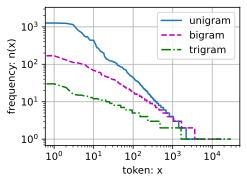

In [26]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot(X =[freqs, bigram_freqs, trigram_freqs],
         xlabel='token: x', ylabel='frequency: n(x)',
         legend=['unigram', 'bigram', 'trigram'],
         xscale='log', yscale='log')

# Language models

In [27]:
import torch
from d2l import torch as d2l

Note that *unigram* models are those that do not condition on any previous token,
*bigram* models those that condition on a single token and so on.

The probability of a single word is referred to not as the total frequency, but the frequency of sentences starting with that word. If we apply this line of reasoning to bigram, trigrams et cetera, it becomes evident that it is impossible to model most of the word combinations.

## Laplace Smoothing

Let $m$ be the number of unique words in the dataset.

$$\begin{split}\begin{aligned}
    \hat{P}(x) & = \frac{n(x) + \epsilon_1/m}{n + \epsilon_1}, \\
    \hat{P}(x' \mid x) & = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
    \hat{P}(x'' \mid x,x') & = \frac{n(x, x',x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}.
\end{aligned}\end{split}$$

## Perplexity

Since Laplacian smoothing is still not a satisfying answer, we can try to use an information theory approach. Let's consider the quantity

$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1)$$
here, $x_t$ is the token actually observed at timestep t. Now we can define complexity as
$$\exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right)$$
Note how this is a probability. If the model $P$ is valid, this tends to 1.

## Partitioning sequences

Consider the $$m = \lfloor \frac{T-d}{n} \rfloor$$
subsequences obtained by discarding the first $d \sim Unif(n)$\
Let $\mathbf{x}_t = [x_t, ... x_{t+n-1}]$ be the length-n subsequence starting at $x_t$.\
These $m$ partitioned subsequences will be used as an input sequence to the language model.\
The goal in this case is to predict $\mathbf{x}_{t+1} | \mathbf{x}_t$.

In [ ]:
@d2l.add_to_class(d2l.TimeMachine)      #@save
def __init__(self, batch_size, num_step, num_train=10000, num_val=5000):
    super(d2l.TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self.download())
    array = torch.tensor